# Checking Supervised Information Cohesion 

In [1]:
import os
import numpy as np
import pandas as pd

from pyspark.sql import functions as F

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import dextra.dna.core as C
import dextra.dna.text as T
import dextra.dna.commons as P

Using local environment.


In [3]:
spark = P.config.spark

pd.set_option('display.max_colwidth', 200)

sns.set()

## Reading Dataset

In [4]:
DATA_FILE = P.config.lakes.refined + '/issues.encoded.parquet'

x = C.io.stream.read(DATA_FILE)

x.limit(2).toPandas()

,complaint_id,consumer_message,customer_name,date_received,disputed,issue,product,resolution,state,sub_issue,...,via,zip_code,ingested_at,tags_trusted_labels,tags_split,text_cleaned,committed_at,text_cleaned_words,text_cleaned_filtered,features
0,024f01fdf2f6,"After realizing that my rescission rights were still effective due to the fact that my loan has not yet been consummated under the laws of California, I sent Ocwen Loan Servicing , LLC a letter re...",bc606596ca8b,2015-09-09,False,"Loan modification,collection,foreclosure",Mortgage,Closed with explanation,CA,None,...,Web,91317,2020-12-20 12:41:50.904213,False,train,after realizing that my rescission rights were still effective due to the fact that my loan has not yet been consummated under the laws of california i sent ocwen loan servicing llc a letter resci...,2020-12-20 12:51:11.543374,"[after, realizing, that, my, rescission, rights, were, still, effective, due, to, the, fact, that, my, loan, has, not, yet, been, consummated, under, the, laws, of, california, i, sent, ocwen, loa...","[realizing, rescission, rights, still, effective, due, fact, loan, yet, consummated, laws, california, sent, ocwen, loan, servicing, llc, letter, rescinding, loan, {numeric}, {numeric}, {numeric},...","[0.016033735401195254, 0.022905139435835657, -0.0773088897886795, -0.020218425399047616, -0.028350271218941805, 0.06511233462887057, 0.035688524669472206, -0.0004988416913739514, 0.022763795743230..."
1,0264246c03dd,Bank of America is not reporting correctly on my credit. They included my mortgage in a Bankruptcy when I had paperwork with in my bankruptcy indicating possible re-affirmation. I continued to mak...,62c86e89ae4e,2015-07-27,True,"Loan servicing, payments, escrow account",Mortgage,Closed with non-monetary relief,UT,None,...,Web,84010,2020-12-20 12:41:50.904213,False,train,bank of america is not reporting correctly on my credit they included my mortgage in a bankruptcy when i had paperwork with in my bankruptcy indicating possible re affirmation i continued to make ...,2020-12-20 12:51:11.543374,"[bank, of, america, is, not, reporting, correctly, on, my, credit, they, included, my, mortgage, in, a, bankruptcy, when, i, had, paperwork, with, in, my, bankruptcy, indicating, possible, re, aff...","[bank, america, reporting, correctly, credit, included, mortgage, bankruptcy, paperwork, bankruptcy, indicating, possible, re, affirmation, continued, make, payments, time, also, indicating, reaff...","[0.044086923824669035, -0.07230800897890671, -0.0006964051576911427, 0.010883117501135367, 0.044695720206335436, -0.008737844796698603, 0.0729917399737923, -0.005619275032496844, -0.08871804436182..."


## Checking Products Labels

We simulate only a few rows contain trustworthy information in its tags.
For example, we have only been able to verify the accuracy of ~150 samples from the entire set.

We will use `clustering` on top of the learned embedding (word2vec) to figure it out if the average pattern behind these labels is solid.

In [5]:
from pyspark.sql import Window

ws = (Window
       .partitionBy('product')
       .orderBy(F.desc('date_received')))

xs = (x.withColumn('nth', F.row_number().over(ws))
       .where(F.col('nth') < 300))

In [6]:
print('records                    :', x.count())
print('300 most recent/product    :', xs.count())
print('records with trusted labels:', xs.where(xs.tags_trusted_labels).count())

records                    : 199970
300 most recent/product    : 5092
records with trusted labels: 522


### Affinity Through the Cosine Similarity

Spark does not have a cosine implementation:
```
cos(u, v) = (u . v) * (1/||u||) * (1/||v||)
```

However, we can use this neat trick to create it:
```
(a*u) . v = a * (u . v)
=> (u . v) * (1/||u||) * (1/||v||)
=  (u/||u||) . (v/||v||)
```

That is, the cosine similarity is the simple dot product between 
**normal** vectors.

In [7]:
from pyspark.ml.feature import Normalizer

def normalize(x):
    normalizer = Normalizer(inputCol='features', outputCol='features_norm')
    return normalizer.transform(x)

x_ = normalize(xs).select(
    'complaint_id',
    'tags_trusted_labels',
    'features_norm',
    'product'
).toPandas()

x_.head(2)

,complaint_id,tags_trusted_labels,features_norm,product
0,4cfabf259f1f,False,"[0.05744252571706755, -0.03122081024915247, -0.05993527655482161, -0.10953633706106726, 0.031672682276373335, -0.15334218260964577, 0.08893704586648363, -0.13859500072399486, -0.008867291027657282...",Debt collection
1,9f29fe1890ab,False,"[0.13219752652616432, 0.13948848282123505, -0.006157630209026474, -0.12627453101048378, -0.011369343856421065, -0.12078751753351825, 0.07478531486268489, -0.026758442100742356, 0.02503681451167497...",Debt collection


In [8]:
x_.size

20368

From all samples collected, only contain a few labels that we trust --- those we have manually curated ---.

In [9]:
dict(zip(*np.unique(x_.tags_trusted_labels, return_counts=True)))

{False: 4570, True: 522}

In [10]:
from sklearn import metrics

fn = np.asarray([r for r in x_.features_norm])
cs = np.inner(fn, fn)

In [11]:
cs[:5].round(2)

array([[1.  , 0.68, 0.52, ..., 0.2 , 0.14, 0.6 ],
       [0.68, 1.  , 0.73, ..., 0.23, 0.19, 0.63],
       [0.52, 0.73, 1.  , ..., 0.11, 0.28, 0.65],
       [0.66, 0.71, 0.5 , ..., 0.1 , 0.03, 0.31],
       [0.25, 0.4 , 0.2 , ..., 0.54, 0.6 , 0.55]])

In [12]:
# Take 5 most similar neighbors, removing one-self (last column)
# and accounting for -1 indexing shifting.
nb = cs.argsort(axis=1)[:, -2:-7:-1]
nb_sim = np.asarray([cs[i, nb[i]] for i in range(len(cs))])

In [13]:
nb[:5]

array([[ 947,  267,  511, 2767,  178],
       [4825,   89, 3114,  214,  199],
       [  41,  431, 4604,  488, 2899],
       [4394,   13, 4825, 2810, 3971],
       [ 483, 5034, 4268, 5044, 4908]])

In [14]:
nb_sim[:5].round(2)

array([[0.84, 0.81, 0.81, 0.81, 0.8 ],
       [0.88, 0.85, 0.84, 0.83, 0.83],
       [0.89, 0.89, 0.88, 0.87, 0.87],
       [0.78, 0.74, 0.72, 0.72, 0.71],
       [0.87, 0.86, 0.86, 0.86, 0.85]])

#### Infferring Neighbors Based on Affinity

We "contaminate" each non-trusted complaint with
the label of its most similar trusted neighbor.

In [15]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE

z = TSNE().fit_transform(fn)
y = MiniBatchKMeans().fit_predict(fn)
y = [f'cluster {e}' for e in y]

x_['cluster'] = y

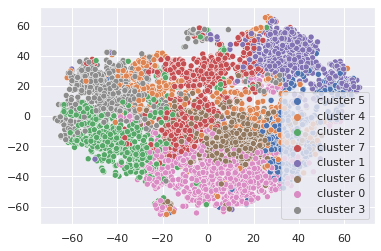

In [16]:
_x, _y = z.T

sns.scatterplot(x=_x, y=_y, hue=y);

In [17]:
ht = (x_[x_.tags_trusted_labels]
      .groupby(['product', 'cluster'], as_index=False)
      .agg({'complaint_id': 'count'})
      .pivot('product', 'cluster', 'complaint_id')
      .fillna(0))

# Transform counts in rates
ht = ht / ht.sum(axis=1).values.reshape(-1, 1)

# Sort from most coherent to most unsure
ht = (ht.assign(max=ht.max(axis=1))  
        .sort_values('max', ascending=False)
        .drop('max', 1))

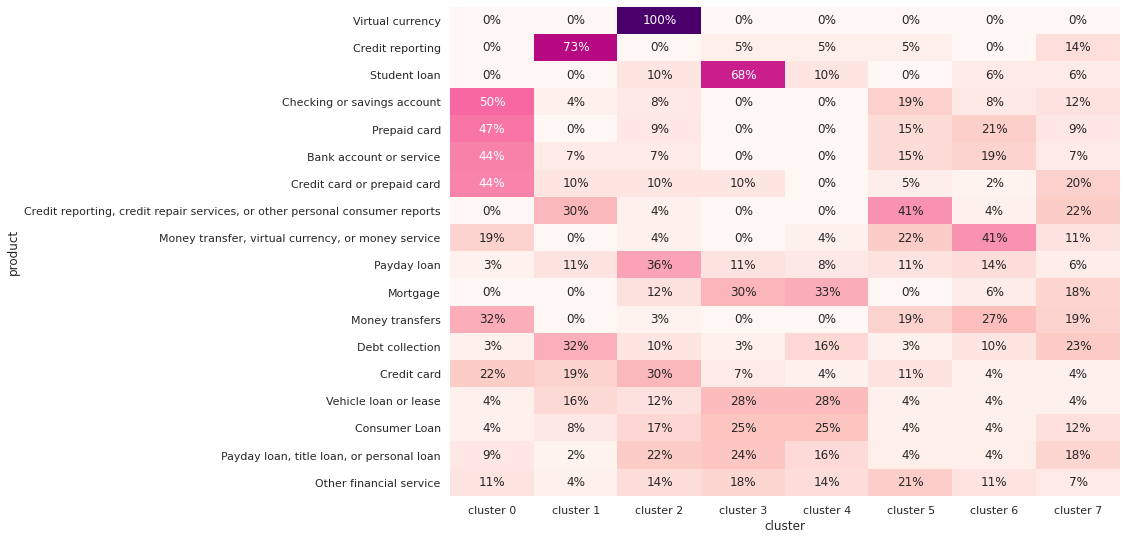

In [18]:
plt.figure(figsize=(12, 9))
ax = sns.heatmap(ht, cmap='RdPu', fmt='.0%', annot=True, cbar=False);

## Checking Issue Label Cohesion

In [19]:
x_ = normalize(xs).select(
    'complaint_id',
    'tags_trusted_labels',
    'features_norm',
    'issue'
).toPandas()

x_.head(2)

,complaint_id,tags_trusted_labels,features_norm,issue
0,4cfabf259f1f,False,"[0.05744252571706755, -0.03122081024915247, -0.05993527655482161, -0.10953633706106726, 0.031672682276373335, -0.15334218260964577, 0.08893704586648363, -0.13859500072399486, -0.008867291027657282...",Communication tactics
1,9f29fe1890ab,False,"[0.13219752652616432, 0.13948848282123505, -0.006157630209026474, -0.12627453101048378, -0.011369343856421065, -0.12078751753351825, 0.07478531486268489, -0.026758442100742356, 0.02503681451167497...",Communication tactics


In [20]:
dict(zip(*np.unique(x_.tags_trusted_labels, return_counts=True)))

{False: 4570, True: 522}

In [28]:
print(f'Issues ({len(x_.issue.unique())} total):',
      *x_.issue.unique()[:10],
      '...',
      sep='\n')

Issues (135 total):
Communication tactics
False statements or representation
Attempts to collect debt not owed
Took or threatened to take negative or legal action
Written notification about debt
Threatened to contact someone or share information improperly
Other transaction issues
Other service issues
Fraud or scam
Money was not available when promised
...


In [29]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE

z = TSNE().fit_transform(fn)
y = MiniBatchKMeans(32).fit_predict(fn)
y = [f'cluster {e}' for e in y]

x_['cluster'] = y

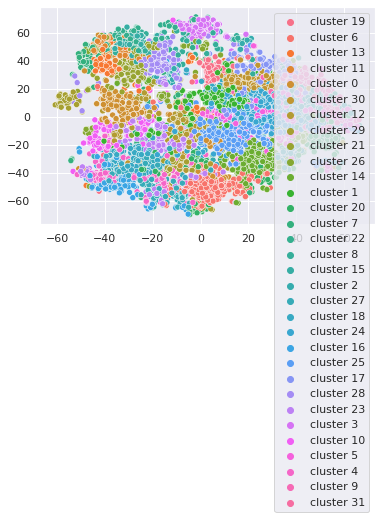

In [30]:
_x, _y = z.T

sns.scatterplot(x=_x, y=_y, hue=y);

In [32]:
ht = (x_[x_.tags_trusted_labels]
      .groupby(['issue', 'cluster'], as_index=False)
      .agg({'complaint_id': 'count'})
      .pivot('issue', 'cluster', 'complaint_id')
      .fillna(0))

# Transform counts in rates
ht = ht / ht.sum(axis=1).values.reshape(-1, 1)

# Sort from most coherent to most unsure
ht = (ht.assign(max=ht.max(axis=1))  
        .sort_values('max', ascending=False)
        .drop('max', 1))

In [43]:
ht.max(axis=1)

issue
APR or interest rate                        1.000000
Credit determination                        1.000000
Delinquent account                          1.000000
Getting a line of credit                    1.000000
Getting the loan                            1.000000
                                              ...   
Fraud or scam                               0.189189
Managing an account                         0.187500
Managing the loan or lease                  0.166667
Account opening, closing, or management     0.166667
Problems at the end of the loan or lease    0.166667
Length: 98, dtype: float64

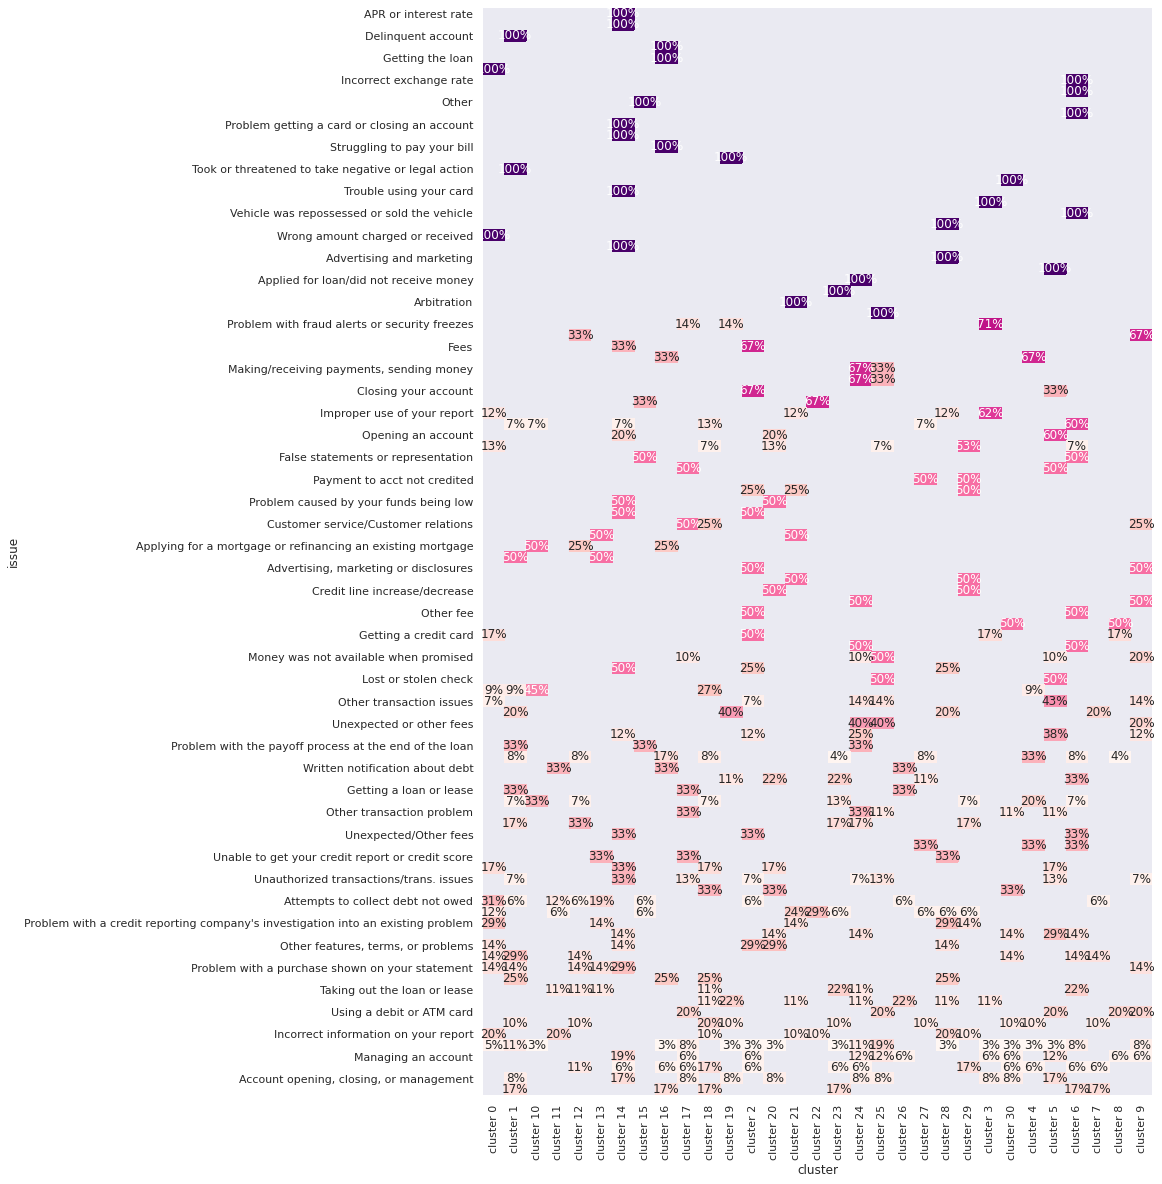

In [36]:
plt.figure(figsize=(12, 20))
sns.heatmap(ht, mask=ht == 0, cmap='RdPu', fmt='.0%', annot=True, cbar=False);